# Equilibration of FOCI-OpenIFS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.stats import linregress

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [ ]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33927 instead
  expected, actual


In [ ]:
client

In [ ]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir2 = '/gxfs_work1/geomar/smomw352/esm-slask/'
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

In [ ]:
# NEMO mesh
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)

# Read data

In [ ]:
exp_list = ['FOCI_GJK001']

In [8]:
# NEMO TOP
ds_top_all = []
for exp in exp_list:
    top = '%s/%s/outdata/nemo/1y/*1y*ptrc_T.nc' % (esmdir,exp)
    ds_top = xr.open_mfdataset(top,combine='by_coords',use_cftime=True).rename({'time_counter':'time'})
    ds_top_all.append(ds_top)

# Global mean age tracer

Depth = 300 
Depth = 700 
Depth = 1500 
Depth = 3000 


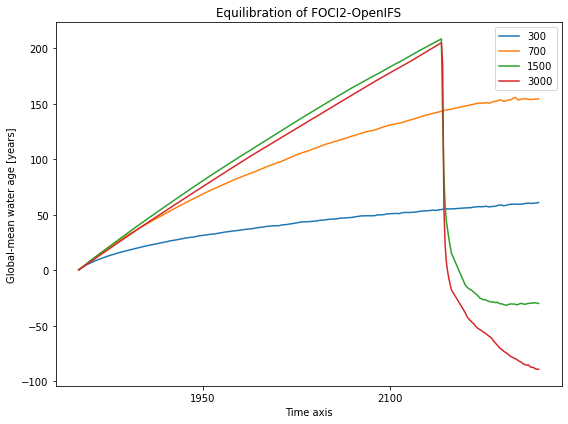

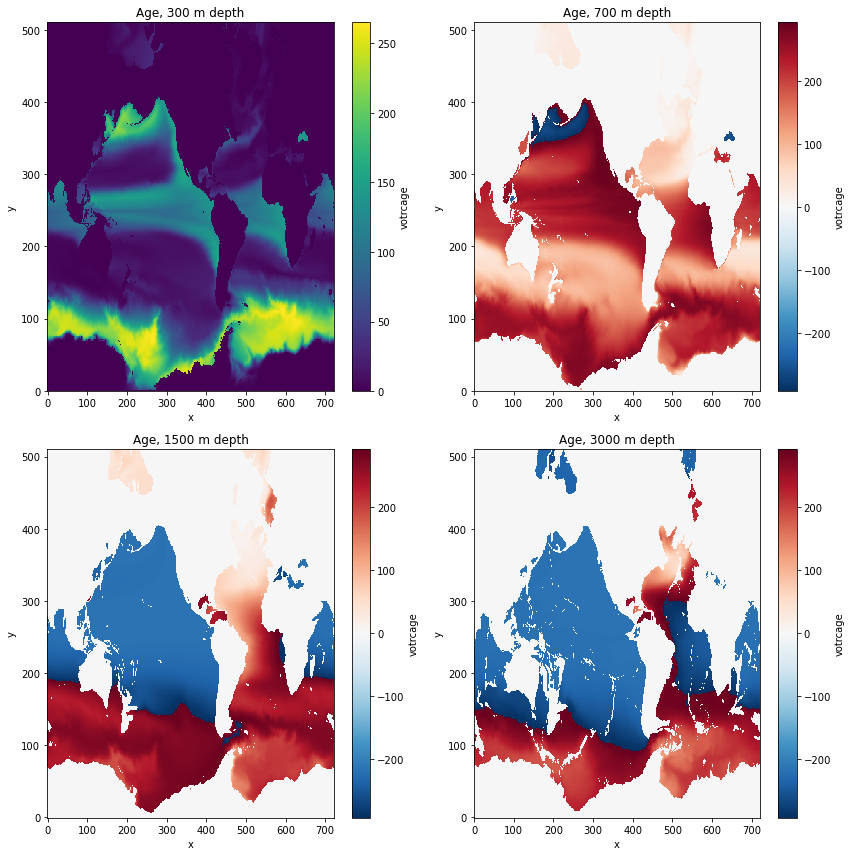

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

fig2, ax2 = plt.subplots(2,2,figsize=(12,12))
axs2 = ax2.flat

scale = 1. / (1e9 * 86400 * 365)

for i in range(0,len(exp_list)):
    ds_top = ds_top_all[i]
    
    j = 0
    for dep in [300,700,1500,3000]:
        # Age tracer
        print('Depth = %d ' % (dep,))
        trage = ds_top['votrcage'].sel(deptht=dep,method='nearest')
        trage_float = trage.astype('float32') * scale
        
        # Plot last time steps
        trage_float[-1,:,:].plot(ax=axs2[j])
        axs2[j].set_title('Age, %d m depth' % (dep,))
        
        # Weighted global mean
        trage_wgt = trage_float.where(da_orca05_mask == 1).weighted(da_orca05_area)
        trage_mean = trage_wgt.mean(('x','y'))
        trage_mean.plot(ax=ax,label='%d' % (dep,))
        
        j = j+1

ax.legend()
ax.set_ylabel('Global-mean water age [years]')
ax.set_title('Equilibration of FOCI2-OpenIFS')
fig.tight_layout()
fig2.tight_layout()
fig.savefig('equilibration_tracer_age.pdf',format='pdf')